In [21]:
USE_CATEGORICAL = False
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml.dask.ensemble import RandomForestClassifier as cuRF_mg
import cupy as cp
from cuml.preprocessing import LabelEncoder
from cuml.preprocessing import train_test_split
import cudf, cupy, cuml, math, warnings, time 
from numba import cuda, float32, int8
import numpy as np, pandas as pd, os, gc
warnings.filterwarnings("ignore")

LOCAL_VALIDATION = False

SEED=0

In [22]:
result_table = cudf.DataFrame(columns=['Method', 'Preprocessing','Training','Inference'])

In [23]:


# LIST COLUMNS TO LOAD
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# USEFUL V COLUMNS
cols = cols + ['V'+str(x) for x in range(1,340)]

# DECLARE COLUMN DTYPES
dtypes_trasactions= {'isFraud':'float32'}
for c in cols: dtypes_trasactions[c] = 'float32'
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9']
for c in str_type: dtypes_trasactions[c] = 'str'
#for c in str_type: dtypes[c] = 'str'
str_type_trasactions = str_type
dtypes_identity = {'TransactionID':'float32'}
for c in ['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: dtypes_identity[c] = 'float32'
str_type = ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
for c in str_type: dtypes_identity[c] = 'str'
str_type = str_type + str_type_trasactions
print('RAPIDS =',cudf.__version__)



RAPIDS = 23.08.00


In [24]:

start = time.time()

X_train = cudf.read_csv('train_transaction.csv', dtype=dtypes_trasactions)
train_id = cudf.read_csv('train_identity.csv',dtype=dtypes_identity)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

print('Train shape on GPU',X_train.shape)

for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
       
# LABEL ENCODE
def encode_LE(df1,col,verbose=True):
    df1[col] = df1[col].factorize()[0].astype('int32')
    if verbose: print(col,', ',end='')
        
# SET NAN to -1
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES. SET NAN to -1
    if (X_train[f].dtype=='object'): 
        encode_LE(X_train,f,False)
    elif f in str_type:
        X_train[f].fillna(-1,inplace=True)
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionID','TransactionAmt','TransactionDT','isFraud']:
        mn = np.min((X_train[f].min()))
        X_train[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)


X_final = X_train

X = X_final.drop('isFraud', axis=1)
y = X_final.isFraud.astype(int)                   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
# Copy data to avoid slowdowns due to fragmentation
X_train = X_train.copy()
X_test = X_test.copy()

end = time.time()
rapids_pp_time = end - start
print("Total Preprocessing time using GPU and rapids:",rapids_pp_time)

Train shape on GPU (590540, 435)
Total Preprocessing time using GPU and rapids: 2.5342915058135986


In [5]:
import xgboost as xgb

In [6]:
# Define model training function
def train_model(num_trees, max_depth):
    model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        enable_categorical=USE_CATEGORICAL,
        use_label_encoder=False,
        predictor='gpu_predictor',
        eval_metric='aucpr',
        objective='binary:logistic',
        max_depth=max_depth,
        n_estimators=num_trees
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )
    return model

In [21]:
model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        use_label_encoder=False,
        predictor='gpu_predictor',
        eval_metric='aucpr',
        objective='binary:logistic',
        max_depth=8,
        n_estimators=1000
    )

In [22]:
xgb_param = model.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
    metrics='aucpr', early_stopping_rounds=50)


In [23]:
cvresult.shape[0]

1000

In [13]:
#Include dentity
start = time.time()

large_model = train_model(1000, 20)

end = time.time()
print("Total model training time for XGBoost using GPU and RAPIDS:",end - start)

[0]	validation_0-aucpr:0.55584
[1]	validation_0-aucpr:0.59027
[2]	validation_0-aucpr:0.61968
[3]	validation_0-aucpr:0.64554
[4]	validation_0-aucpr:0.66001
[5]	validation_0-aucpr:0.67491
[6]	validation_0-aucpr:0.69260
[7]	validation_0-aucpr:0.70719
[8]	validation_0-aucpr:0.72224
[9]	validation_0-aucpr:0.73590
[10]	validation_0-aucpr:0.74682
[11]	validation_0-aucpr:0.75577
[12]	validation_0-aucpr:0.76336
[13]	validation_0-aucpr:0.76955
[14]	validation_0-aucpr:0.77778
[15]	validation_0-aucpr:0.78261
[16]	validation_0-aucpr:0.78891
[17]	validation_0-aucpr:0.79333
[18]	validation_0-aucpr:0.79612
[19]	validation_0-aucpr:0.79867
[20]	validation_0-aucpr:0.80105
[21]	validation_0-aucpr:0.80316
[22]	validation_0-aucpr:0.80547
[23]	validation_0-aucpr:0.80696
[24]	validation_0-aucpr:0.80790
[25]	validation_0-aucpr:0.80954
[26]	validation_0-aucpr:0.81077
[27]	validation_0-aucpr:0.81136
[28]	validation_0-aucpr:0.81246
[29]	validation_0-aucpr:0.81295
[30]	validation_0-aucpr:0.81428
[31]	validation_0-

In [7]:
#Include dentity
start = time.time()

large_model = train_model(2000, 8)

end = time.time()
rapids_training_time = end - start
print("Total model training time for XGBoost using GPU and RAPIDS:",rapids_training_time)

[0]	validation_0-aucpr:0.44810
[1]	validation_0-aucpr:0.47131
[2]	validation_0-aucpr:0.48765
[3]	validation_0-aucpr:0.50966
[4]	validation_0-aucpr:0.53273
[5]	validation_0-aucpr:0.54665
[6]	validation_0-aucpr:0.56051
[7]	validation_0-aucpr:0.57116
[8]	validation_0-aucpr:0.57839
[9]	validation_0-aucpr:0.59050
[10]	validation_0-aucpr:0.59851
[11]	validation_0-aucpr:0.60308
[12]	validation_0-aucpr:0.61188
[13]	validation_0-aucpr:0.61501
[14]	validation_0-aucpr:0.62114
[15]	validation_0-aucpr:0.62727
[16]	validation_0-aucpr:0.63561
[17]	validation_0-aucpr:0.64200
[18]	validation_0-aucpr:0.64971
[19]	validation_0-aucpr:0.65792
[20]	validation_0-aucpr:0.66373
[21]	validation_0-aucpr:0.66631
[22]	validation_0-aucpr:0.66911
[23]	validation_0-aucpr:0.67389
[24]	validation_0-aucpr:0.67912
[25]	validation_0-aucpr:0.68308
[26]	validation_0-aucpr:0.68512
[27]	validation_0-aucpr:0.69179
[28]	validation_0-aucpr:0.69326
[29]	validation_0-aucpr:0.69589
[30]	validation_0-aucpr:0.69890
[31]	validation_0-

In [8]:
import gc

gc.collect()

103

In [9]:
large_model.save_model("large_model.json")

In [10]:
start = time.time()
y_score_xgb = large_model.predict_proba(X_test)[:,1]
end = time.time()
rapids_inference_time = end - start
print("Total model inference time for XGBoost using GPU and RAPIDS:",rapids_inference_time)
y_test_pandas = y_test.to_pandas()

Total model inference time for XGBoost using GPU and RAPIDS: 0.870922327041626


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc # classification metrics


In [12]:
precision, recall, thresholds = precision_recall_curve(y_test_pandas, y_score_xgb)
auc_precision_recall = auc(recall, precision)
precision, recall, auc_precision_recall


(array([0.03499057, 0.03499077, 0.03499097, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.03855461, 0.02806904,
        0.        ]),
 0.8432401660121805)

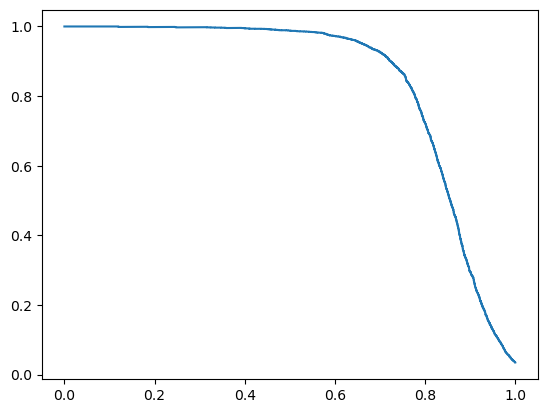

In [13]:
plt.plot(recall, precision)
plt.show()

In [14]:
start = time.time()
xgb_pred = large_model.predict(X_test)
end = time.time()
print("Inference Time using GPU and RAPIDS:",end - start)

Inference Time using GPU and RAPIDS: 0.8538753986358643


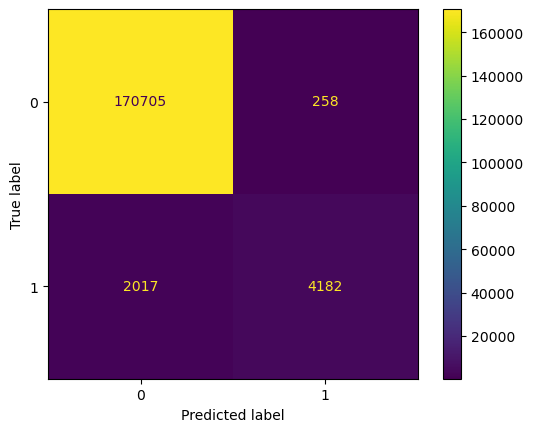



              precision    recall  f1-score   support

           0       0.99      1.00      0.99    170963
           1       0.94      0.67      0.79      6199

    accuracy                           0.99    177162
   macro avg       0.97      0.84      0.89    177162
weighted avg       0.99      0.99      0.99    177162



In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
y_test_pandas = y_test.to_pandas()

accuracy_score(y_test_pandas, xgb_pred)
fpr, tpr, _ = roc_curve(y_test_pandas,  xgb_pred)
auc = roc_auc_score(y_test_pandas, xgb_pred)

cm = confusion_matrix(y_test_pandas,xgb_pred, labels=large_model.classes_.get())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=large_model.classes_.get()).plot()
plt.show()
print('\n')
print(classification_report(y_test_pandas,xgb_pred))


In [ ]:

start = time.time()

X_train = pd.read_csv('train_transaction.csv', dtype=dtypes_trasactions)
train_id = pd.read_csv('train_identity.csv',dtype=dtypes_identity)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

print('Train shape on GPU',X_train.shape)

for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
       
# LABEL ENCODE
def encode_LE(df1,col,verbose=True):
    df1[col] = df1[col].factorize()[0].astype('int32')
    if verbose: print(col,', ',end='')
        
# SET NAN to -1
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES. SET NAN to -1
    if (X_train[f].dtype=='object'): 
        encode_LE(X_train,f,False)
    elif f in str_type:
        X_train[f].fillna(-1,inplace=True)
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionID','TransactionAmt','TransactionDT','isFraud']:
        mn = np.min((X_train[f].min()))
        X_train[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)


X_final = X_train

X = X_final.drop('isFraud', axis=1)
y = X_final.isFraud.astype(int)                   


from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
# Copy data to avoid slowdowns due to fragmentation
X_train = X_train.copy()
X_test = X_test.copy()

end = time.time()
CPU_pp_time = end - start


In [27]:
print("Total Preprocessing time using Pandas and CPU:",CPU_pp_time)

Total Preprocessing time using Pandas and CPU: 55.399827003479004


In [31]:
# Define model training function
def train_model(num_trees, max_depth):
    model = xgb.XGBClassifier(
        tree_method='hist',
        enable_categorical=USE_CATEGORICAL,
        use_label_encoder=False,
        predictor='cpu_predictor',
        eval_metric='aucpr',
        objective='binary:logistic',
        max_depth=max_depth,
        n_estimators=num_trees
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )
    return model

In [32]:
#Include dentity
start = time.time()

large_model = train_model(2000, 8)

end = time.time()
CPU_training_time = end - start
print("Total model training time for XGBoost using CPU:",CPU_training_time)

[0]	validation_0-aucpr:0.42906
[1]	validation_0-aucpr:0.46820
[2]	validation_0-aucpr:0.49926
[3]	validation_0-aucpr:0.51014
[4]	validation_0-aucpr:0.53551
[5]	validation_0-aucpr:0.54451
[6]	validation_0-aucpr:0.55528
[7]	validation_0-aucpr:0.57450
[8]	validation_0-aucpr:0.58513
[9]	validation_0-aucpr:0.59820
[10]	validation_0-aucpr:0.60694
[11]	validation_0-aucpr:0.61493
[12]	validation_0-aucpr:0.62057
[13]	validation_0-aucpr:0.62873
[14]	validation_0-aucpr:0.63185
[15]	validation_0-aucpr:0.63753
[16]	validation_0-aucpr:0.64323
[17]	validation_0-aucpr:0.65062
[18]	validation_0-aucpr:0.65383
[19]	validation_0-aucpr:0.65815
[20]	validation_0-aucpr:0.66779
[21]	validation_0-aucpr:0.67397
[22]	validation_0-aucpr:0.67568
[23]	validation_0-aucpr:0.68005
[24]	validation_0-aucpr:0.68420
[25]	validation_0-aucpr:0.68861
[26]	validation_0-aucpr:0.68958
[27]	validation_0-aucpr:0.69059
[28]	validation_0-aucpr:0.69294
[29]	validation_0-aucpr:0.69521
[30]	validation_0-aucpr:0.69772
[31]	validation_0-

In [35]:
start = time.time()
y_score_xgb = large_model.predict_proba(X_test)[:,1]
end = time.time()
CPU_inference_time = end - start
print("Total model inference time for XGBoost using CPU:",CPU_inference_time)


Total model inference time for XGBoost using CPU: 2.152533531188965


In [36]:
result_table = result_table.append({'Method':'RAPIDS',
                                        'Preprocessing':rapids_pp_time, 
                                        'Training':rapids_training_time, 
                                        'Inference':0.8538753986358643}, ignore_index=True)


In [37]:
result_table = result_table.append({'Method':'CPU',
                                        'Preprocessing':CPU_pp_time, 
                                        'Training':CPU_training_time, 
                                        'Inference':CPU_inference_time}, ignore_index=True)


In [54]:
result_table.set_index("Method")

,Preprocessing,Training,Inference
Method,,,
RAPIDS,2.534292,38.881558,0.853875
CPU,55.399827,1097.518646,2.152534
Faster,22.000000,28.000000,3.000000


In [59]:
cudf.DataFrame({'':'Faster',
                                        'Preprocessing':str(int(round(CPU_pp_time/rapids_pp_time,0))) + 'x', 
                                        'Training':str(int(round(CPU_training_time/rapids_training_time,0))) + 'x', 
                                        'Inference':str(int(round(CPU_inference_time/0.8538753986358643,0))) + 'x'}, index = '')


,,Preprocessing,Training,Inference
,Faster,22x,28x,3x


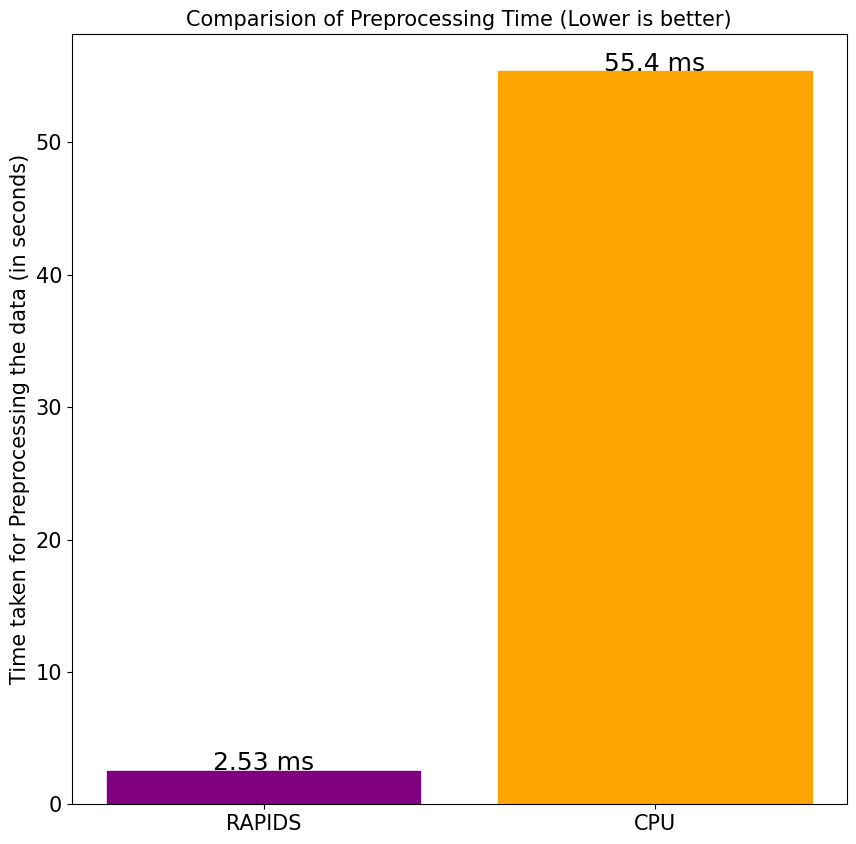

In [60]:
fig = plt.figure(figsize = (10, 10))
y = [round(rapids_pp_time,2),round(CPU_pp_time,2)]
plt.rcParams.update({'font.size': 15})
# creating the bar plot
barr = plt.bar(['RAPIDS','CPU'], y)
barr[0].set_color('purple')
barr[1].set_color('orange')
plt.ylabel("Time taken for Preprocessing the data (in seconds)",fontdict=dict(fontsize=15))
plt.title("Comparision of Preprocessing Time (Lower is better)",fontdict=dict(fontsize=15))
for index,data in enumerate(y):
    plt.text(x=index , y =data +0.03, s=f"{data} ms" ,ha='center', fontdict=dict(fontsize=18))
plt.show()

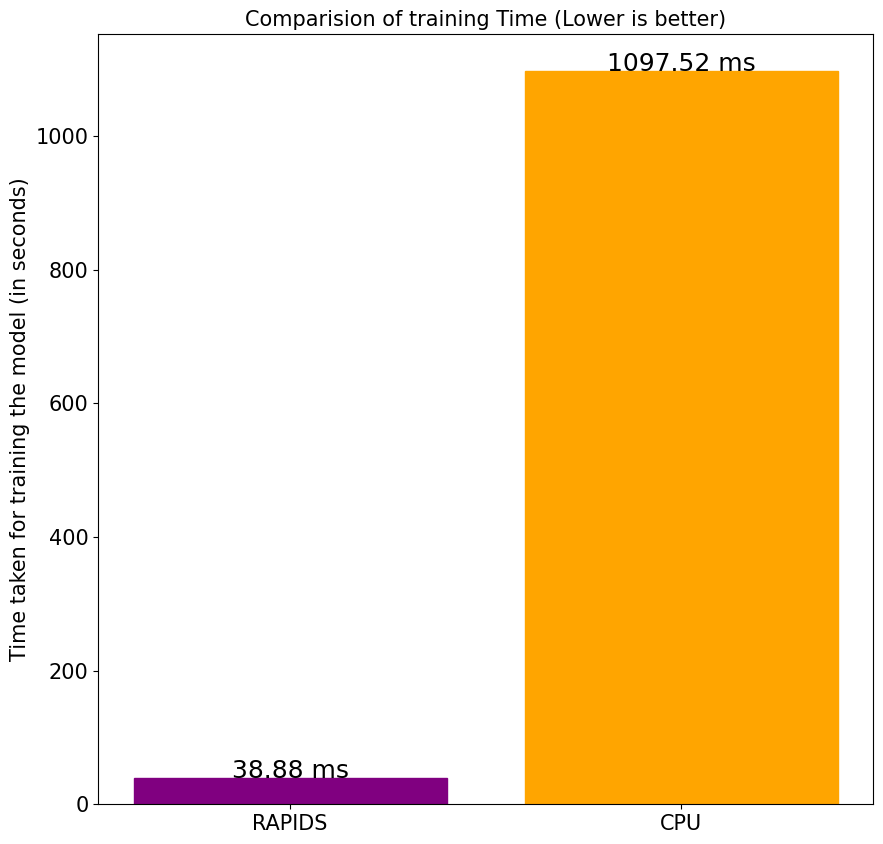

In [63]:
fig = plt.figure(figsize = (10, 10))
y = [round(rapids_training_time,2),round(CPU_training_time,2)]
plt.rcParams.update({'font.size': 15})
# creating the bar plot
barr = plt.bar(['RAPIDS','CPU'], y)
barr[0].set_color('purple')
barr[1].set_color('orange')
plt.ylabel("Time taken for training the model (in seconds)",fontdict=dict(fontsize=15))
plt.title("Comparision of training Time (Lower is better)",fontdict=dict(fontsize=15))
for index,data in enumerate(y):
    plt.text(x=index , y =data +0.03, s=f"{data} ms" ,ha='center', fontdict=dict(fontsize=18))
plt.show()

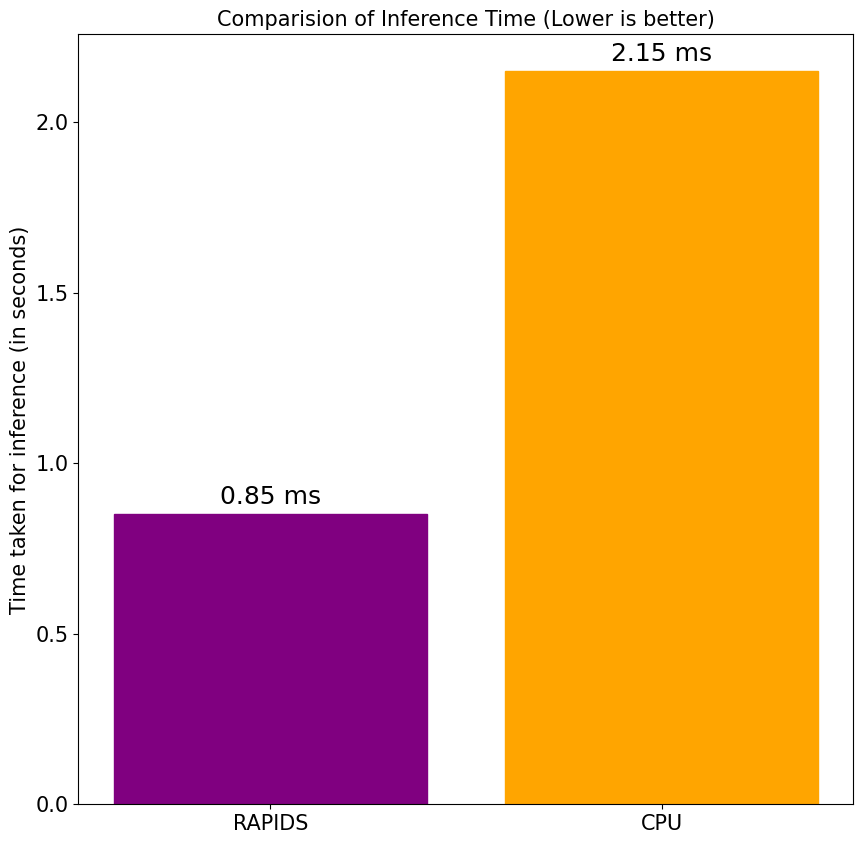

In [64]:
fig = plt.figure(figsize = (10, 10))
y = [round(0.8538753986358643,2),round(CPU_inference_time,2)]
plt.rcParams.update({'font.size': 15})
# creating the bar plot
barr = plt.bar(['RAPIDS','CPU'], y)
barr[0].set_color('purple')
barr[1].set_color('orange')
plt.ylabel("Time taken for inference (in seconds)",fontdict=dict(fontsize=15))
plt.title("Comparision of Inference Time (Lower is better)",fontdict=dict(fontsize=15))
for index,data in enumerate(y):
    plt.text(x=index , y =data +0.03, s=f"{data} ms" ,ha='center', fontdict=dict(fontsize=18))
plt.show()